In [41]:
import strawberryfields as sf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter

# --- CONFIGURATION ---
sf.hbar = 1
np.random.seed(42)

# Parameters
eta, delta = 0.9, 0.01
num_steps = 200
learning_rate = 0.003  # Adjusted for epsilon optimization
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
mu = np.pi/4  # Fixed LO phase for this optimization

# --- Helper Functions ---
def db_to_epsilon(db_val: float) -> float:
    """
    Convert a given GKP squeezing level in dB to epsilon via:
         tanh(epsilon) = 10^(-db_val/10)
    """
    t = 10.0 ** (-db_val / 10.0)
    eps = 0.5 * np.log((1.0 + t) / (1.0 - t))
    return eps

def epsilon_to_db(epsilon: float) -> float:
    """Convert epsilon to dB value"""
    t = np.tanh(epsilon)
    return -10.0 * np.log10(t)

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0, Nphi=15, phi_clip=3.0):
    """
    Prepare GKP state under loss (eta) and approximate dephasing (gamma),
    returning its 2D Wigner function on the grid 'quad_axis'.
    """
    prog = sf.Program(1)
    eng = sf.Engine("bosonic")

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        W = state.wigner(0, quad_axis, quad_axis)
        return W

    # Otherwise, approximate dephasing by averaging over random rotations
    phis = np.linspace(-phi_clip*phi_std, phi_clip*phi_std, Nphi)
    dphi = phis[1] - phis[0]
    weights = np.exp(-0.5*(phis/phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0,0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)
    return wigner_avg

def compute_wigner_derivatives(epsilon, eta, delta, d_eta=1e-3, d_delta=1e-3):
    """
    Compute the derivatives of Wigner function with respect to eta and delta
    using central difference method
    """
    # Base Wigner function
    W_base = prepare_gkp_state(epsilon, eta, delta)
    
    # Compute dW/deta using central difference
    W_eta_plus = prepare_gkp_state(epsilon, eta + d_eta/2, delta)
    W_eta_minus = prepare_gkp_state(epsilon, eta - d_eta/2, delta)
    dW_deta = (W_eta_plus - W_eta_minus) / d_eta
    
    # Compute dW/ddelta using central difference
    W_delta_plus = prepare_gkp_state(epsilon, eta, delta + d_delta/2)
    W_delta_minus = prepare_gkp_state(epsilon, eta, delta - d_delta/2)
    dW_ddelta = (W_delta_plus - W_delta_minus) / d_delta
    
    return W_base, dW_deta, dW_ddelta

def compute_qfi_bound(dW_deta, dW_ddelta):
    """
    Compute the QFI bound using Wigner function derivatives
    For multi-parameter case: F_total = F_eta_eta + F_delta_delta
    """
    dq = quad_axis[1] - quad_axis[0]
    dp = dq
    
    # Compute F_eta_eta ≤ 4π∫(∂_η W)² dq dp
    F_eta_eta = 4 * np.pi * np.sum(dW_deta**2) * dq * dp
    
    # Compute F_delta_delta ≤ 4π∫(∂_δ W)² dq dp
    F_delta_delta = 4 * np.pi * np.sum(dW_ddelta**2) * dq * dp
    
    # Total QFI (trace of QFI matrix)
    F_total = F_eta_eta + F_delta_delta
    
    return F_total, F_eta_eta, F_delta_delta

def compute_qfi_gradient(epsilon, eta, delta, d_epsilon=1e-3):
    """
    Compute the gradient of the QFI bound with respect to epsilon
    using central difference method
    """
    # Compute QFI at epsilon + d_epsilon/2
    _, dW_deta_plus, dW_ddelta_plus = compute_wigner_derivatives(
        epsilon + d_epsilon/2, eta, delta)
    F_total_plus, _, _ = compute_qfi_bound(dW_deta_plus, dW_ddelta_plus)
    
    # Compute QFI at epsilon - d_epsilon/2
    _, dW_deta_minus, dW_ddelta_minus = compute_wigner_derivatives(
        epsilon - d_epsilon/2, eta, delta)
    F_total_minus, _, _ = compute_qfi_bound(dW_deta_minus, dW_ddelta_minus)
    
    # Compute gradient
    grad_epsilon = (F_total_plus - F_total_minus) / d_epsilon
    
    return grad_epsilon


def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu


def compute_marginal_mse_epsilon(epsilon_values):
    """Compute marginal MSE for epsilon optimization."""
    mse_values = []

    phi_fixed = np.pi/4   # fixed quadrature angle for measurement

    for epsilon in epsilon_values:
        W_ideal = prepare_gkp_state(epsilon=epsilon, eta=1.0, gamma=0.0)
        W_noisy = prepare_gkp_state(epsilon=epsilon, eta=eta, gamma=delta)

        P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=phi_fixed)
        P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=phi_fixed)

        mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
        mse_values.append(mse)

    return mse_values

In [42]:
# Main optimization loop
# Initialize with ~10 dB squeezing
epsilon = db_to_epsilon(14.9)
epsilon_min = db_to_epsilon(18.0) 
epsilon_max = db_to_epsilon(10.0)   

print(f"Initial epsilon: {epsilon:.4f} (equivalent to {epsilon_to_db(epsilon):.2f} dB)")

qfi_history, epsilon_history, gradient_history = [], [], []
velocity = 0
momentum = 0.9

for step in tqdm(range(num_steps)):
    # Compute Wigner derivatives
    W, dW_deta, dW_ddelta = compute_wigner_derivatives(epsilon, eta, delta)
    
    # Compute current QFI bound
    F_total, F_eta_eta, F_delta_delta = compute_qfi_bound(dW_deta, dW_ddelta)
    
    # Compute gradient of QFI with respect to epsilon
    grad_epsilon = compute_qfi_gradient(epsilon, eta, delta)
    
    # Clip gradient to prevent too large steps
    grad_epsilon = np.clip(grad_epsilon, -0.05, 0.05)
    
    # Momentum-based gradient ascent update
    velocity = momentum * velocity + learning_rate * grad_epsilon
    epsilon += velocity
    
    # Ensure epsilon stays within bounds
    epsilon = np.clip(epsilon, epsilon_min, epsilon_max)
    
    # Store history
    qfi_history.append(F_total)
    epsilon_history.append(epsilon)
    gradient_history.append(grad_epsilon)
    
    if step % 5 == 0:
        db_val = epsilon_to_db(epsilon)
        print(f"Step {step}: ε={epsilon:.4f} ({db_val:.2f} dB), " 
              f"QFI={F_total:.4e}, F_η={F_eta_eta:.4e}, F_δ={F_delta_delta:.4e}")


Initial epsilon: 0.0324 (equivalent to 14.90 dB)


  0%|          | 1/200 [07:29<24:51:38, 449.74s/it]

Step 0: ε=0.0325 (14.88 dB), QFI=1.7274e+02, F_η=1.2522e+01, F_δ=1.6022e+02


  3%|▎         | 6/200 [44:10<23:33:06, 437.05s/it]

Step 5: ε=0.0350 (14.56 dB), QFI=1.7795e+02, F_η=1.2934e+01, F_δ=1.6502e+02


  6%|▌         | 11/200 [1:18:04<21:21:36, 406.86s/it]

Step 10: ε=0.0396 (14.02 dB), QFI=1.8706e+02, F_η=1.3676e+01, F_δ=1.7338e+02


  8%|▊         | 16/200 [1:48:44<18:55:27, 370.26s/it]

Step 15: ε=0.0454 (13.44 dB), QFI=1.9544e+02, F_η=1.4394e+01, F_δ=1.8105e+02


 10%|█         | 21/200 [2:16:35<16:45:36, 337.07s/it]

Step 20: ε=0.0518 (12.86 dB), QFI=2.0120e+02, F_η=1.4912e+01, F_δ=1.8628e+02


 13%|█▎        | 26/200 [2:42:08<14:56:50, 309.26s/it]

Step 25: ε=0.0587 (12.32 dB), QFI=2.0408e+02, F_η=1.5176e+01, F_δ=1.8890e+02


 16%|█▌        | 31/200 [3:05:41<13:22:24, 284.88s/it]

Step 30: ε=0.0650 (11.88 dB), QFI=2.0451e+02, F_η=1.5199e+01, F_δ=1.8931e+02


 18%|█▊        | 36/200 [3:28:01<12:19:02, 270.38s/it]

Step 35: ε=0.0663 (11.79 dB), QFI=2.0424e+02, F_η=1.5164e+01, F_δ=1.8907e+02


 20%|██        | 41/200 [3:50:28<11:56:31, 270.39s/it]

Step 40: ε=0.0639 (11.95 dB), QFI=2.0447e+02, F_η=1.5193e+01, F_δ=1.8927e+02


 23%|██▎       | 46/200 [4:13:47<11:57:29, 279.54s/it]

Step 45: ε=0.0603 (12.20 dB), QFI=2.0455e+02, F_η=1.5214e+01, F_δ=1.8934e+02


 26%|██▌       | 51/200 [4:37:44<11:49:40, 285.78s/it]

Step 50: ε=0.0607 (12.17 dB), QFI=2.0452e+02, F_η=1.5213e+01, F_δ=1.8931e+02


 28%|██▊       | 56/200 [5:01:06<11:12:49, 280.35s/it]

Step 55: ε=0.0631 (12.01 dB), QFI=2.0458e+02, F_η=1.5211e+01, F_δ=1.8937e+02


 30%|███       | 61/200 [5:24:16<10:45:26, 278.61s/it]

Step 60: ε=0.0621 (12.08 dB), QFI=2.0459e+02, F_η=1.5212e+01, F_δ=1.8937e+02


 33%|███▎      | 66/200 [5:47:34<10:23:48, 279.31s/it]

Step 65: ε=0.0623 (12.06 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 36%|███▌      | 71/200 [6:10:46<9:58:31, 278.39s/it] 

Step 70: ε=0.0619 (12.09 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 38%|███▊      | 76/200 [6:33:44<9:29:23, 275.51s/it]

Step 75: ε=0.0621 (12.08 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 40%|████      | 81/200 [6:56:55<9:10:49, 277.73s/it]

Step 80: ε=0.0617 (12.10 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8937e+02


 43%|████▎     | 86/200 [7:19:59<8:45:09, 276.40s/it]

Step 85: ε=0.0625 (12.05 dB), QFI=2.0459e+02, F_η=1.5213e+01, F_δ=1.8937e+02


 46%|████▌     | 91/200 [7:42:51<8:19:10, 274.77s/it]

Step 90: ε=0.0622 (12.07 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8938e+02


 48%|████▊     | 96/200 [8:05:43<7:55:48, 274.50s/it]

Step 95: ε=0.0623 (12.06 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 50%|█████     | 101/200 [8:28:37<7:33:28, 274.83s/it]

Step 100: ε=0.0620 (12.08 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8937e+02


 53%|█████▎    | 106/200 [8:51:28<7:09:51, 274.38s/it]

Step 105: ε=0.0620 (12.08 dB), QFI=2.0459e+02, F_η=1.5213e+01, F_δ=1.8938e+02


 56%|█████▌    | 111/200 [9:14:22<6:47:32, 274.74s/it]

Step 110: ε=0.0620 (12.08 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 58%|█████▊    | 116/200 [9:37:13<6:24:06, 274.37s/it]

Step 115: ε=0.0619 (12.09 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 60%|██████    | 121/200 [10:00:07<6:01:17, 274.39s/it]

Step 120: ε=0.0625 (12.05 dB), QFI=2.0459e+02, F_η=1.5213e+01, F_δ=1.8938e+02


 63%|██████▎   | 126/200 [10:22:57<5:38:22, 274.36s/it]

Step 125: ε=0.0620 (12.08 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8937e+02


 66%|██████▌   | 131/200 [10:45:51<5:15:46, 274.58s/it]

Step 130: ε=0.0623 (12.06 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 68%|██████▊   | 136/200 [11:08:44<4:53:06, 274.78s/it]

Step 135: ε=0.0618 (12.09 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8937e+02


 70%|███████   | 141/200 [11:31:34<4:29:20, 273.91s/it]

Step 140: ε=0.0623 (12.06 dB), QFI=2.0459e+02, F_η=1.5213e+01, F_δ=1.8937e+02


 73%|███████▎  | 146/200 [11:54:28<4:07:24, 274.90s/it]

Step 145: ε=0.0622 (12.07 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 76%|███████▌  | 151/200 [12:17:21<3:44:21, 274.73s/it]

Step 150: ε=0.0621 (12.07 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 78%|███████▊  | 156/200 [12:40:15<3:21:27, 274.71s/it]

Step 155: ε=0.0624 (12.06 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 80%|████████  | 161/200 [13:03:05<2:58:18, 274.31s/it]

Step 160: ε=0.0619 (12.09 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 83%|████████▎ | 166/200 [13:25:56<2:35:27, 274.32s/it]

Step 165: ε=0.0621 (12.08 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 86%|████████▌ | 171/200 [13:48:49<2:12:39, 274.45s/it]

Step 170: ε=0.0618 (12.10 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8937e+02


 88%|████████▊ | 176/200 [14:11:40<1:49:35, 273.98s/it]

Step 175: ε=0.0625 (12.05 dB), QFI=2.0459e+02, F_η=1.5213e+01, F_δ=1.8937e+02


 90%|█████████ | 181/200 [14:34:33<1:26:59, 274.69s/it]

Step 180: ε=0.0622 (12.07 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8938e+02


 93%|█████████▎| 186/200 [14:57:28<1:04:07, 274.82s/it]

Step 185: ε=0.0623 (12.06 dB), QFI=2.0459e+02, F_η=1.5214e+01, F_δ=1.8938e+02


 96%|█████████▌| 191/200 [15:20:22<41:14, 274.94s/it]  

Step 190: ε=0.0620 (12.08 dB), QFI=2.0459e+02, F_η=1.5215e+01, F_δ=1.8937e+02


 98%|█████████▊| 196/200 [15:43:11<18:16, 274.11s/it]

Step 195: ε=0.0620 (12.08 dB), QFI=2.0459e+02, F_η=1.5213e+01, F_δ=1.8938e+02


100%|██████████| 200/200 [16:01:28<00:00, 288.44s/it]


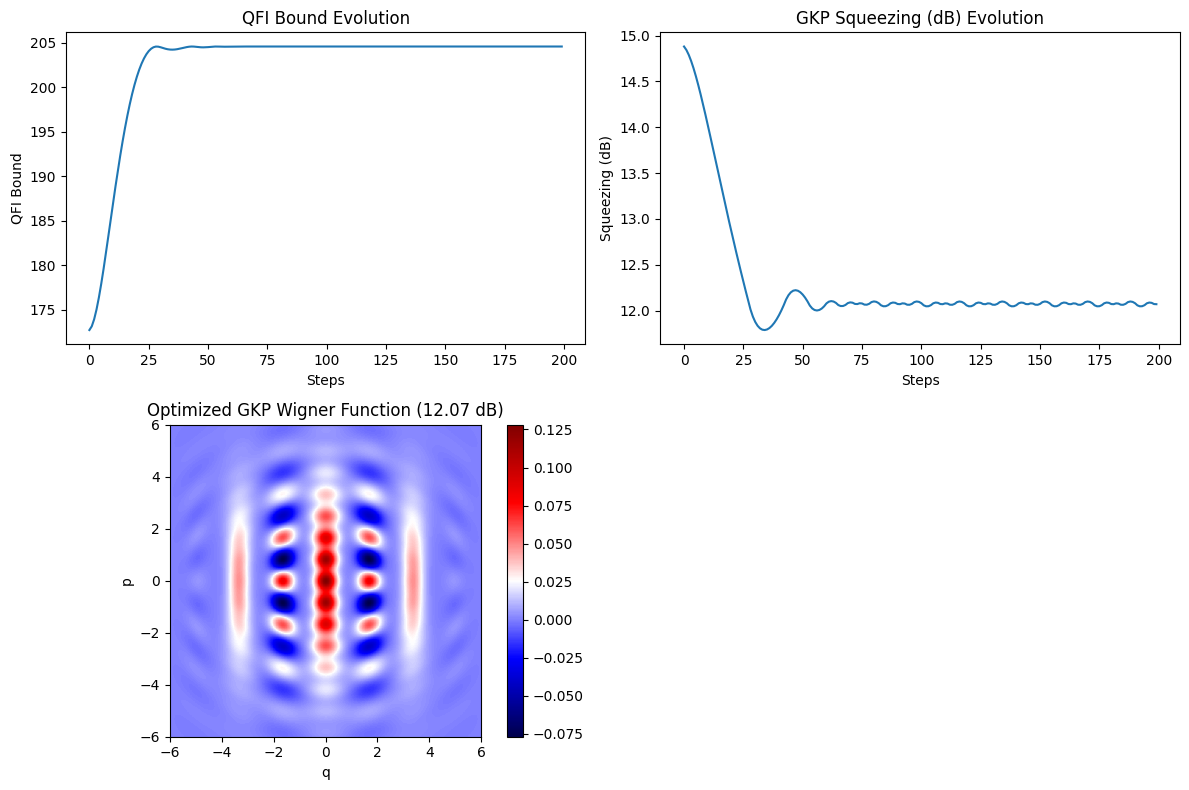

Optimization complete!
Final epsilon: 0.0622 (equivalent to 12.07 dB)
Final QFI bound: 2.045901e+02


In [43]:
# Plot results
plt.figure(figsize=(12, 8))

# Plot 1: QFI evolution
plt.subplot(2, 2, 1)
plt.plot(qfi_history)
plt.title('QFI Bound Evolution')
plt.xlabel('Steps')
plt.ylabel('QFI Bound')

# Plot 2: Epsilon evolution
plt.subplot(2, 2, 2)
plt.plot([epsilon_to_db(eps) for eps in epsilon_history])
plt.title('GKP Squeezing (dB) Evolution')
plt.xlabel('Steps')
plt.ylabel('Squeezing (dB)')


# Plot 4: Final Wigner function
plt.subplot(2, 2, 3)
plt.imshow(W, extent=[quad_axis[0], quad_axis[-1], quad_axis[0], quad_axis[-1]], 
           origin='lower', cmap='seismic')
plt.title(f'Optimized GKP Wigner Function ({epsilon_to_db(epsilon):.2f} dB)')
plt.xlabel('q')
plt.ylabel('p')
plt.colorbar()

plt.tight_layout()
plt.savefig('gkp_optimization_results.png')
plt.show()

print(f"Optimization complete!")
print(f"Final epsilon: {epsilon:.4f} (equivalent to {epsilon_to_db(epsilon):.2f} dB)")
print(f"Final QFI bound: {qfi_history[-1]:.6e}")

### Save the result

In [44]:
# Save the data to text files
# Basic version using NumPy's savetxt
np.savetxt(f'C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta{eta}_delta{delta}_init15.txt', 
           np.column_stack((
               np.arange(len(qfi_history)),
               epsilon_history,
               [epsilon_to_db(eps) for eps in epsilon_history],
               qfi_history,
           )),
           delimiter='\t',
           header='Step\tEpsilon\tSqueezing(dB)\tQFI_Total',
           fmt=['%d', '%.6f', '%.4f', '%.6e'])

print(f"Optimization data saved to gkp_optimization_eta{eta}_delta{delta}.txt")

Optimization data saved to gkp_optimization_eta0.9_delta0.01.txt


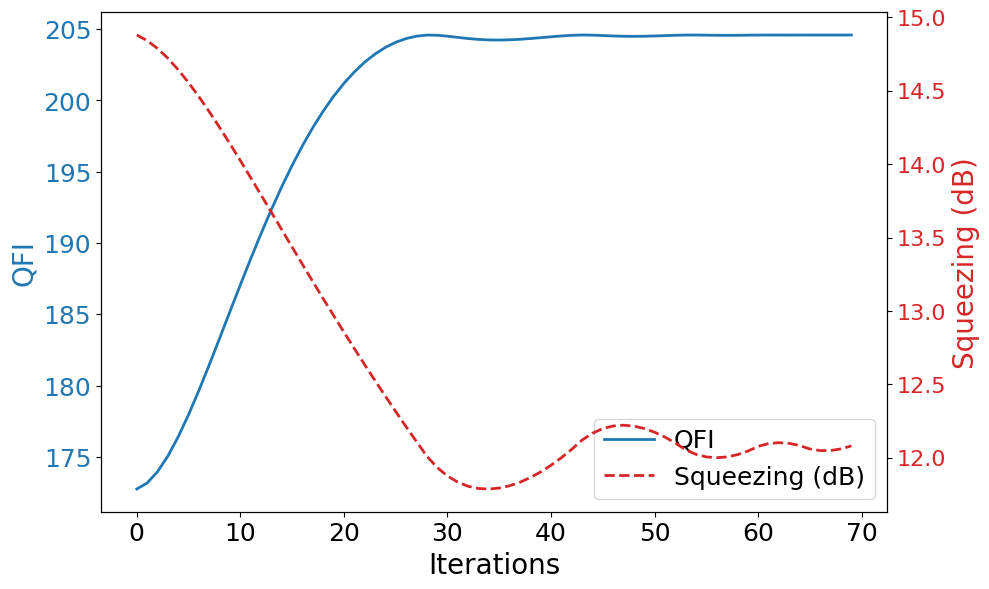

In [48]:
import matplotlib.pyplot as plt

steps_to_plot = 70  # Limit to the first 70 steps

fig, ax1 = plt.subplots(figsize=(10, 6))

color_qfi = 'tab:blue'
color_squeeze = 'tab:red'

# Slice data to the first 70 steps
qfi_to_plot = qfi_history[:steps_to_plot]
squeeze_to_plot = [epsilon_to_db(eps) for eps in epsilon_history[:steps_to_plot]]

# Plot QFI on primary y-axis
ax1.set_xlabel('Iterations', fontsize=20)
ax1.set_ylabel('QFI', fontsize=20, color=color_qfi)
ax1.plot(range(steps_to_plot), qfi_to_plot, color=color_qfi, linewidth=2, label='QFI')
ax1.tick_params(axis='y', labelcolor=color_qfi, labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

# Create secondary y-axis for squeezing
ax2 = ax1.twinx()
ax2.set_ylabel('Squeezing (dB)', fontsize=20, color=color_squeeze)
ax2.plot(range(steps_to_plot), squeeze_to_plot, 
         color=color_squeeze, linewidth=2, linestyle='--', label='Squeezing (dB)')
ax2.tick_params(axis='y', labelcolor=color_squeeze, labelsize=18)

# ax1.grid(True)

# Legends (optional, recommended)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
lines_qfi, labels_qfi = ax1.get_legend_handles_labels()
lines_squeeze, labels_squeeze = ax2.get_legend_handles_labels()
ax1.legend(lines_qfi + lines_squeeze, labels_qfi + labels_squeeze, fontsize=18, loc='best')

plt.tight_layout()
plt.savefig('combined_qfi_squeezing_evolution_70_steps.png', dpi=800)
plt.show()


# MSE

Calculating MSE for ε optimization...


Computing MSE: 100%|██████████| 200/200 [1:08:18<00:00, 20.49s/it]


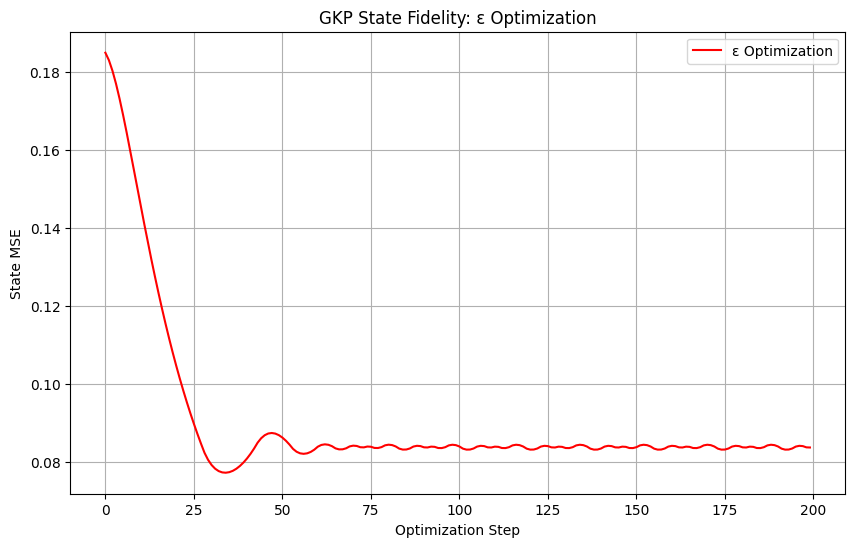

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import strawberryfields as sf

# --- File Paths ---
filename_qfi = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta0.9_delta0.01_init15.txt"

# --- Parameters ---
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
eta, delta = 0.9, 0.01  # Channel parameters

# --- Helper Functions ---
def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0):
    """Prepare GKP state under loss (eta) and dephasing (gamma), returning its Wigner function."""
    prog = sf.Program(1)
    eng = sf.Engine("bosonic", backend_options={"cutoff_dim": 32})

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    # Approximate dephasing by averaging
    phis = np.linspace(-3 * phi_std, 3 * phi_std, 15)
    weights = np.exp(-0.5 * (phis / phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def compute_wigner_mse(W_ideal, W_noisy, quad_axis):
    """Compute MSE between two Wigner functions."""
    dq = quad_axis[1] - quad_axis[0]
    dp = dq

    W_ideal /= np.sum(W_ideal) * dq * dp
    W_noisy /= np.sum(W_noisy) * dq * dp

    return np.sum((W_ideal - W_noisy)**2) * dq * dp

def compute_state_mse_wigner(epsilon, eta, delta):
    """Compute Wigner MSE for identical epsilon (ideal vs. noisy)."""
    W_ideal = prepare_gkp_state(epsilon=epsilon, eta=1.0, gamma=0.0)
    W_noisy = prepare_gkp_state(epsilon=epsilon, eta=eta, gamma=delta)
    return compute_wigner_mse(W_ideal, W_noisy, quad_axis)

def compute_mse_optimization(param_history):
    """Compute MSE for epsilon optimization history."""
    mse_values = []
    for param in tqdm(param_history, desc="Computing MSE"):
        mse = compute_state_mse_wigner(epsilon=param, eta=eta, delta=delta)
        mse_values.append(mse)
    return mse_values

# --- Main Execution ---
if __name__ == "__main__":
    qfi_data = np.loadtxt(filename_qfi, delimiter='\t', skiprows=1)
    epsilon_history = qfi_data[:, 1]

    print("Calculating MSE for ε optimization...")
    mse_epsilon = compute_mse_optimization(epsilon_history)

    plt.figure(figsize=(10, 6))
    plt.plot(mse_epsilon, label='ε Optimization', color='red')
    plt.xlabel('Optimization Step')
    plt.ylabel('State MSE')
    plt.title('GKP State Fidelity: ε Optimization')
    plt.legend()
    plt.grid(True)
    plt.show()

Calculating marginal MSE for ε optimization...


Computing Marginal MSE (ε): 100%|██████████| 200/200 [1:08:12<00:00, 20.46s/it]


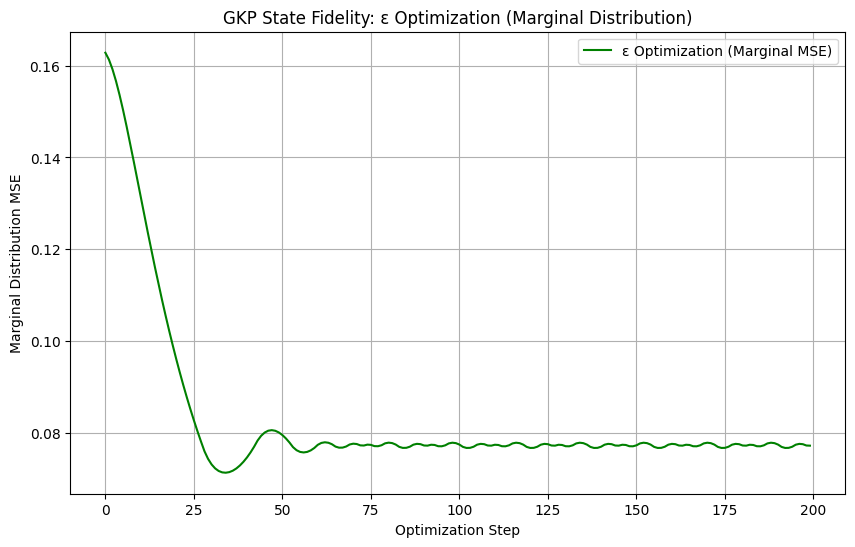

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import strawberryfields as sf

# --- File Paths ---
filename_qfi = "C:/Users/tvle2/Documents/Code/Bosonic/dataset/QFI/gkp_optimization_eta0.9_delta0.01_init15.txt"

# --- Parameters ---
quad_pts = 200
quad_axis = np.linspace(-6, 6, quad_pts)
eta, delta = 0.9, 0.01  # Channel parameters

# --- Helper Functions ---
def db_to_epsilon(db_val):
    """Convert squeezing in dB to epsilon."""
    t = 10.0 ** (-db_val / 10.0)
    return 0.5 * np.log((1.0 + t) / (1.0 - t))

def prepare_gkp_state(epsilon, eta, gamma, phi=0.0):
    """Prepare GKP state under loss (eta) and dephasing (gamma), returning its Wigner function."""
    prog = sf.Program(1)
    eng = sf.Engine("bosonic", backend_options={"cutoff_dim": 32})

    phi_std = np.sqrt(gamma)
    if gamma < 1e-12:
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            if eta < 1.0:
                sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi) | q[0]
        state = eng.run(prog).state
        return state.wigner(0, quad_axis, quad_axis)

    # Approximate dephasing by averaging
    phis = np.linspace(-3 * phi_std, 3 * phi_std, 15)
    weights = np.exp(-0.5 * (phis / phi_std)**2)
    weights /= weights.sum()

    wigner_avg = np.zeros((quad_pts, quad_pts), dtype=float)
    for phi_val, w in zip(phis, weights):
        prog = sf.Program(1)
        with prog.context as q:
            sf.ops.GKP(state=[0, 0], epsilon=epsilon) | q[0]
            sf.ops.LossChannel(eta) | q[0]
            sf.ops.Rgate(phi_val) | q[0]
        state = eng.run(prog).state
        wigner_avg += w * state.wigner(0, quad_axis, quad_axis)

    return wigner_avg

def marginal_from_wigner(W, xvec, phi):
    """Compute marginal distribution from the Wigner function at angle phi."""
    Q, P = np.meshgrid(xvec, xvec, indexing='xy')
    dq = xvec[1] - xvec[0]

    X = Q * np.cos(phi) + P * np.sin(phi)

    bin_indices = np.floor((X - xvec[0]) / dq).astype(int)
    valid_bins = (bin_indices >= 0) & (bin_indices < len(xvec))

    P_x_mu = np.bincount(bin_indices[valid_bins].ravel(),
                         weights=W[valid_bins].ravel() * dq**2,
                         minlength=len(xvec))

    norm = np.trapz(P_x_mu, xvec)
    if norm > 1e-15:
        P_x_mu /= norm
    return P_x_mu

def compute_marginal_mse_epsilon(epsilon_values):
    """Compute marginal MSE for epsilon optimization."""
    mse_values = []

    phi_fixed = np.pi/4   # fixed quadrature angle for measurement

    for epsilon in tqdm(epsilon_values, desc="Computing Marginal MSE (ε)"):
        W_ideal = prepare_gkp_state(epsilon=epsilon, eta=1.0, gamma=0.0)
        W_noisy = prepare_gkp_state(epsilon=epsilon, eta=eta, gamma=delta)

        P_ideal = marginal_from_wigner(W_ideal, quad_axis, phi=phi_fixed)
        P_noisy = marginal_from_wigner(W_noisy, quad_axis, phi=phi_fixed)

        mse = np.trapz((P_noisy - P_ideal)**2, quad_axis)
        mse_values.append(mse)

    return mse_values

# --- Main Execution ---
if __name__ == "__main__":
    qfi_data = np.loadtxt(filename_qfi, delimiter='\t', skiprows=1)
    epsilon_history = qfi_data[:, 1]

    print("Calculating marginal MSE for ε optimization...")
    mse_epsilon_marginal = compute_marginal_mse_epsilon(epsilon_history)

    plt.figure(figsize=(10, 6))
    plt.plot(mse_epsilon_marginal, label='ε Optimization (Marginal MSE)', color='green')
    plt.xlabel('Optimization Step')
    plt.ylabel('Marginal Distribution MSE')
    plt.title('GKP State Fidelity: ε Optimization (Marginal Distribution)')
    plt.legend()
    plt.grid(True)
    plt.show()


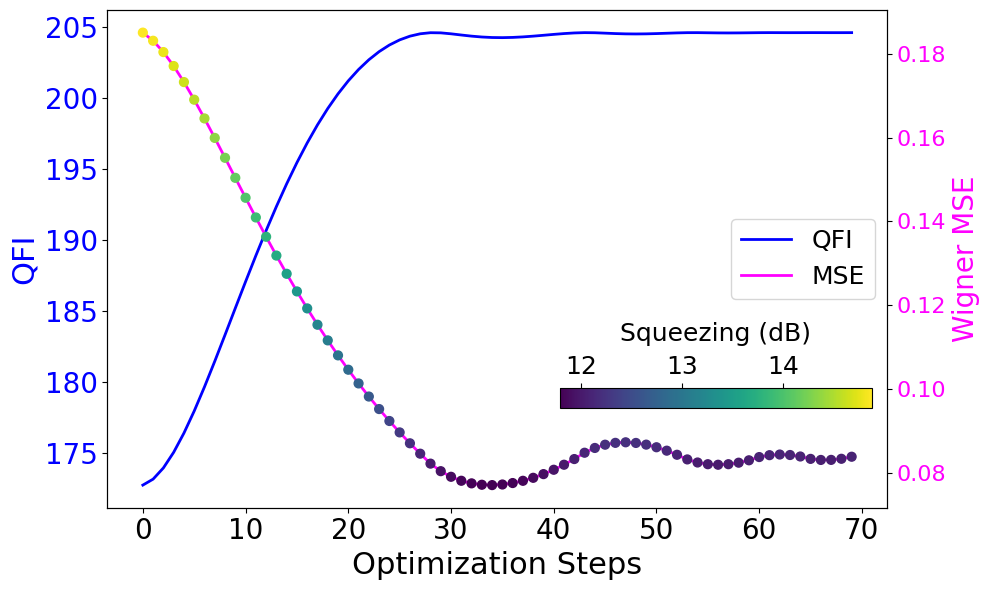

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data ---
steps_to_plot = 70
steps = list(range(steps_to_plot))
qfi_to_plot = qfi_history[:steps_to_plot]
mse_to_plot = mse_epsilon[:steps_to_plot]
squeezing_to_plot = [epsilon_to_db(eps) for eps in epsilon_history[:steps_to_plot]]

# --- Create plot ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# QFI plot (primary y-axis)
ax1.plot(steps, qfi_to_plot, color='blue', linewidth=2, label='QFI')
ax1.set_xlabel('Optimization Steps', fontsize=22)
ax1.set_ylabel('QFI', color='blue', fontsize=22)
ax1.tick_params(axis='y', labelcolor='blue', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)

# MSE plot (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(steps, mse_to_plot, color='magenta', linewidth=2, label='MSE', zorder=1) 
sc = ax2.scatter(steps, mse_to_plot, c=squeezing_to_plot, cmap='viridis', s=40, zorder=2)

ax2.set_ylabel('Wigner MSE', color='magenta', fontsize=20)
ax2.tick_params(axis='y', labelcolor='magenta', labelsize=20)

# Colorbar (vertical, on the right)
cax = ax1.inset_axes([0.58, 0.2, 0.4, 0.04])
cbar = fig.colorbar(sc, cax=cax, orientation="horizontal", shrink=0.5, pad=0.03)
cbar.ax.xaxis.set_label_position('top') 
cbar.ax.xaxis.set_ticks_position('top') 
cbar.set_label('Squeezing (dB)', fontsize = 18, labelpad=10)
cbar.ax.tick_params(labelsize=18)

# Legends (moved below)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=18, loc='center right', ncol=1)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('qfi_mse_pi4.png', dpi=800, bbox_inches='tight')
plt.show()